# Baseline CNN vs CNN+CBAM (Kaggle‑ready)

This notebook trains a **Baseline CNN** and a **CNN + CBAM** with the same hyperparameters (epochs=20), using a **70/15/15** split if needed, and reports:
- Overall accuracy, **per-class accuracy**, Precision, Recall, F1
- Confusion matrix, **ROC/AUC**, learning curves
- **Training time** and **test time**
- Feature extraction from the attention model + **LogReg / SVM / RandomForest**

Edit the dataset path in the first code cell and run all cells (GPU recommended).

In [4]:
import os, time, math, json
from typing import List, Dict, Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# === Dataset paths ===
DATA_BASE = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer"
SUBFOLDER_TRAIN = None
SUBFOLDER_VAL   = None
SUBFOLDER_TEST  = None

# === Hyperparameters (same for both models) ===
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 0.0
IMG_SIZE = 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize,
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize,
])

def _exists(p):
    return p is not None and os.path.isdir(p)

def build_datasets():
    if SUBFOLDER_TRAIN and _exists(os.path.join(DATA_BASE, SUBFOLDER_TRAIN)):
        train_dir = os.path.join(DATA_BASE, SUBFOLDER_TRAIN)
        val_dir   = os.path.join(DATA_BASE, SUBFOLDER_VAL) if SUBFOLDER_VAL else None
        test_dir  = os.path.join(DATA_BASE, SUBFOLDER_TEST) if SUBFOLDER_TEST else None
        train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
        class_names = train_ds.classes
        if val_dir and os.path.isdir(val_dir):
            val_ds = datasets.ImageFolder(val_dir, transform=eval_tfms)
        else:
            n_total = len(train_ds)
            n_val = max(1, int(0.15 * n_total))
            n_train = n_total - n_val
            train_ds, val_ds = torch.utils.data.random_split(train_ds, [n_train, n_val])
            val_ds.dataset.transform = eval_tfms
            train_ds.dataset.transform = train_tfms
        if test_dir and os.path.isdir(test_dir):
            test_ds = datasets.ImageFolder(test_dir, transform=eval_tfms)
        else:
            n_total = len(val_ds)
            n_test = max(1, int(0.5 * n_total))
            n_val2 = n_total - n_test
            val_ds, test_ds = torch.utils.data.random_split(val_ds, [n_val2, n_test])
        return train_ds, val_ds, test_ds, class_names
    else:
        ds_all = datasets.ImageFolder(DATA_BASE, transform=train_tfms)
        class_names = ds_all.classes
        n_total = len(ds_all)
        n_train = int(0.70 * n_total)
        n_val   = int(0.15 * n_total)
        n_test  = n_total - n_train - n_val
        train_ds, val_ds, test_ds = torch.utils.data.random_split(ds_all, [n_train, n_val, n_test])
        train_ds.dataset.transform = train_tfms
        val_ds.dataset.transform   = eval_tfms
        test_ds.dataset.transform  = eval_tfms
        return train_ds, val_ds, test_ds, class_names

train_ds, val_ds, test_ds, class_names = build_datasets()
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print('Dataset sizes:', len(train_ds), len(val_ds), len(test_ds))
print('Classes:', class_names)


Device: cuda
Dataset sizes: 17500 3750 3750
Classes: ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']


In [5]:
# === Models: Baseline and CBAM ===
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        hidden = max(1, in_channels // reduction)
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels, hidden, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.mlp(self.avg_pool(x))
        max_out = self.mlp(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attn = self.sigmoid(self.conv(x_cat))
        return x * attn

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_channels, reduction)
        self.sa = SpatialAttention(kernel_size)
    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

def conv_block(cin, cout):
    return nn.Sequential(
        nn.Conv2d(cin, cout, 3, padding=1),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
        nn.Conv2d(cout, cout, 3, padding=1),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
    )

class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block1 = conv_block(3, 32);  self.pool1 = nn.MaxPool2d(2,2)
        self.block2 = conv_block(32, 64); self.pool2 = nn.MaxPool2d(2,2)
        self.block3 = conv_block(64, 128);self.pool3 = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.block1(x); x = self.pool1(x)
        x = self.block2(x); x = self.pool2(x)
        x = self.block3(x); x = self.pool3(x)
        x = self.gap(x); x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)
    def forward_features(self, x):
        x = self.block1(x); x = self.pool1(x)
        x = self.block2(x); x = self.pool2(x)
        x = self.block3(x); x = self.pool3(x)
        x = self.gap(x); x = torch.flatten(x, 1)
        return x

class CBAMCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block1 = conv_block(3, 32);  self.cbam1 = CBAM(32);  self.pool1 = nn.MaxPool2d(2,2)
        self.block2 = conv_block(32, 64); self.cbam2 = CBAM(64);  self.pool2 = nn.MaxPool2d(2,2)
        self.block3 = conv_block(64, 128);self.cbam3 = CBAM(128); self.pool3 = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.block1(x); x = self.cbam1(x); x = self.pool1(x)
        x = self.block2(x); x = self.cbam2(x); x = self.pool2(x)
        x = self.block3(x); x = self.cbam3(x); x = self.pool3(x)
        x = self.gap(x); x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)
    def forward_features(self, x):
        x = self.block1(x); x = self.cbam1(x); x = self.pool1(x)
        x = self.block2(x); x = self.cbam2(x); x = self.pool2(x)
        x = self.block3(x); x = self.cbam3(x); x = self.pool3(x)
        x = self.gap(x); x = torch.flatten(x, 1)
        return x

num_classes = len(class_names)
baseline = BaselineCNN(num_classes).to(device)
attn = CBAMCNN(num_classes).to(device)
baseline, attn

(BaselineCNN(
   (block1): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
   )
   (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (block2): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
   )
   (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [6]:
def _maybe_sync_cuda():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def train_one_epoch(model, loader, optimizer, device, criterion):
    model.train(); run_loss=0.0; correct=0; total=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(); out = model(x); loss = criterion(out,y); loss.backward(); optimizer.step()
        run_loss += loss.item()*x.size(0)
        _,p = out.max(1); correct += p.eq(y).sum().item(); total += y.size(0)
    return run_loss/max(1,total), correct/max(1,total)

@torch.no_grad()
def evaluate(model, loader, device, criterion):
    model.eval(); run_loss=0.0; correct=0; total=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x); loss = criterion(out,y)
        run_loss += loss.item()*x.size(0)
        _,p = out.max(1); correct += p.eq(y).sum().item(); total += y.size(0)
    return run_loss/max(1,total), correct/max(1,total)

def fit_with_timing(model, train_loader, val_loader, device, epochs=20, lr=1e-3, weight_decay=0.0):
    crit = nn.CrossEntropyLoss(); opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    _maybe_sync_cuda(); t0=time.time()
    for ep in range(epochs):
        tr_l, tr_a = train_one_epoch(model, train_loader, opt, device, crit)
        va_l, va_a = evaluate(model, val_loader, device, crit)
        hist["train_loss"].append(tr_l); hist["train_acc"].append(tr_a)
        hist["val_loss"].append(va_l);   hist["val_acc"].append(va_a)
        print(f"Epoch {ep+1}/{epochs} | train_acc={tr_a:.4f} val_acc={va_a:.4f}")
    _maybe_sync_cuda(); train_sec = time.time()-t0
    _maybe_sync_cuda(); t1=time.time(); _ = evaluate(model, val_loader, device, crit); _maybe_sync_cuda(); val_inf_sec = time.time()-t1
    return train_sec, val_inf_sec, hist

def plot_learning_curves(history, title_prefix=""):
    plt.figure(); plt.plot(history['train_acc'],label='train_acc'); plt.plot(history['val_acc'],label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'{title_prefix} Learning Curve (Accuracy)'); plt.legend(); plt.show()
    plt.figure(); plt.plot(history['train_loss'],label='train_loss'); plt.plot(history['val_loss'],label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'{title_prefix} Learning Curve (Loss)'); plt.legend(); plt.show()

@torch.no_grad()
def collect_logits_and_labels(model, loader, device):
    model.eval(); logits_all=[]; labels_all=[]
    for x,y in loader:
        x = x.to(device); out = model(x)
        logits_all.append(out.cpu()); labels_all.append(y.clone())
    return torch.cat(logits_all), torch.cat(labels_all)

def full_test_report(model, test_loader, device, class_names: List[str]):
    if torch.cuda.is_available(): torch.cuda.synchronize(); t0=time.time()
    else: t0=time.time()
    logits, y_true = collect_logits_and_labels(model, test_loader, device)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    test_seconds_total = time.time()-t0
    probs = F.softmax(logits, dim=1).numpy(); y_true_np = y_true.numpy(); y_pred = probs.argmax(axis=1)
    overall_acc = accuracy_score(y_true_np, y_pred)
    report_str = classification_report(y_true_np, y_pred, target_names=class_names, digits=4)
    cm = confusion_matrix(y_true_np, y_pred)
    # per-class accuracy
    total = cm.sum(); per_class_acc=[]
    for i in range(len(cm)):
        TP=cm[i,i]; FN=cm[i,:].sum()-TP; FP=cm[:,i].sum()-TP; TN=total-(TP+FP+FN)
        per_class_acc.append((TP+TN)/total)
    # ROC/AUC
    num_classes=len(class_names)
    try:
        if num_classes>2:
            y_true_bin = label_binarize(y_true_np, classes=list(range(num_classes)))
            macro_auc = roc_auc_score(y_true_bin, probs, average='macro', multi_class='ovr')
        else:
            macro_auc = roc_auc_score(y_true_np, probs[:,1])
    except Exception:
        macro_auc = float('nan')
    # ROC curves
    if num_classes==2:
        fpr, tpr, _ = roc_curve(y_true_np, probs[:,1])
        plt.figure(); plt.plot(fpr,tpr,label='ROC'); plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Binary)'); plt.legend(); plt.show()
    else:
        y_true_bin = label_binarize(y_true_np, classes=list(range(num_classes)))
        plt.figure()
        for i,cname in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true_bin[:,i], probs[:,i])
            plt.plot(fpr,tpr,label=f'{cname} (AUC={auc(fpr,tpr):.3f})')
        plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (OvR)'); plt.legend(); plt.show()
    # Confusion matrix heatmap
    plt.figure(); im=plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix'); plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks=np.arange(len(class_names)); plt.xticks(ticks, class_names, rotation=45, ha='right'); plt.yticks(ticks, class_names)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j,i,cm[i,j],ha='center',va='center')
    plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()
    return {
        'overall_accuracy': float(overall_acc),
        'classification_report': report_str,
        'confusion_matrix': cm.tolist(),
        'per_class_accuracy': [float(a) for a in per_class_acc],
        'auc_macro': float(macro_auc),
        'test_seconds_total': float(test_seconds_total),
        'test_seconds_per_image': float(test_seconds_total / max(1, len(y_true_np))),
    }


Training Baseline CNN...
Epoch 1/20 | train_acc=0.7960 val_acc=0.7672
Epoch 2/20 | train_acc=0.8741 val_acc=0.9107
Epoch 3/20 | train_acc=0.9019 val_acc=0.9352
Epoch 4/20 | train_acc=0.9226 val_acc=0.9408
Epoch 5/20 | train_acc=0.9371 val_acc=0.9592
Epoch 6/20 | train_acc=0.9421 val_acc=0.9413
Epoch 7/20 | train_acc=0.9492 val_acc=0.9059
Epoch 8/20 | train_acc=0.9542 val_acc=0.9589
Epoch 9/20 | train_acc=0.9594 val_acc=0.9637
Epoch 10/20 | train_acc=0.9613 val_acc=0.9763
Epoch 11/20 | train_acc=0.9659 val_acc=0.9760
Epoch 12/20 | train_acc=0.9675 val_acc=0.9757
Epoch 13/20 | train_acc=0.9671 val_acc=0.9901
Epoch 14/20 | train_acc=0.9740 val_acc=0.9896
Epoch 15/20 | train_acc=0.9749 val_acc=0.9749
Epoch 16/20 | train_acc=0.9767 val_acc=0.9832
Epoch 17/20 | train_acc=0.9780 val_acc=0.9931
Epoch 18/20 | train_acc=0.9765 val_acc=0.9763
Epoch 19/20 | train_acc=0.9814 val_acc=0.9875
Epoch 20/20 | train_acc=0.9811 val_acc=0.9912


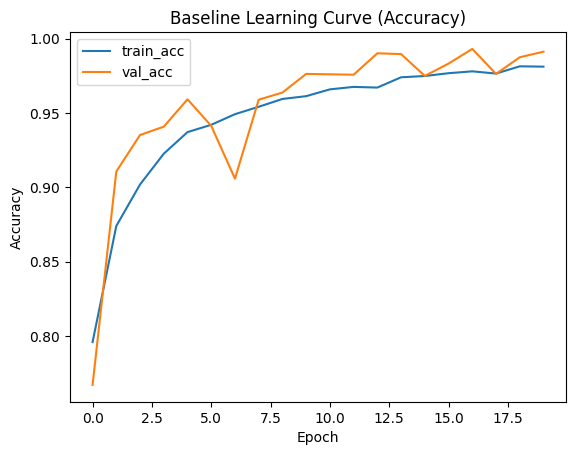

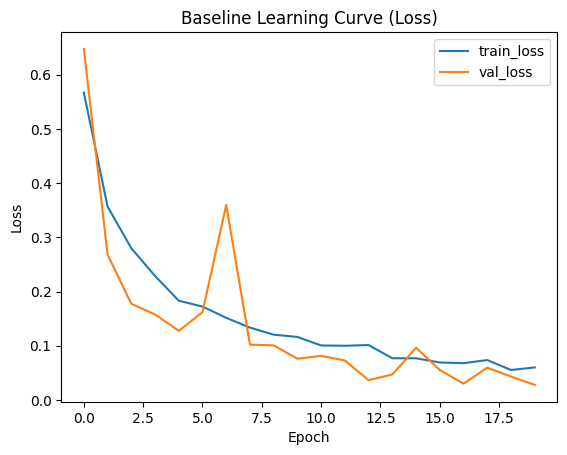


Testing Baseline CNN...


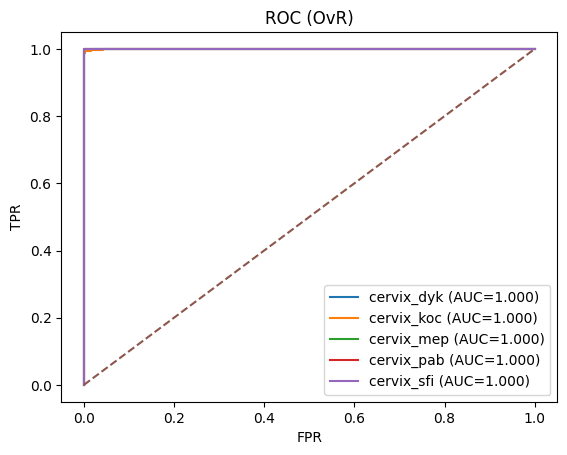

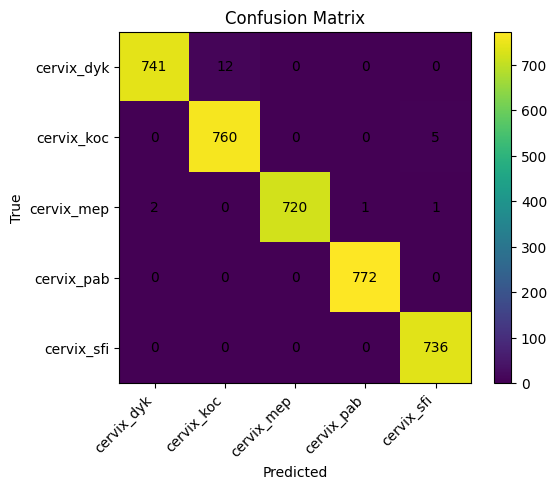

Baseline overall accuracy: 0.9944

Training CNN + CBAM...
Epoch 1/20 | train_acc=0.8570 val_acc=0.9357
Epoch 2/20 | train_acc=0.9333 val_acc=0.9464
Epoch 3/20 | train_acc=0.9580 val_acc=0.9461
Epoch 4/20 | train_acc=0.9651 val_acc=0.9877
Epoch 5/20 | train_acc=0.9712 val_acc=0.9448
Epoch 6/20 | train_acc=0.9799 val_acc=0.9808
Epoch 7/20 | train_acc=0.9790 val_acc=0.9840
Epoch 8/20 | train_acc=0.9849 val_acc=0.9933
Epoch 9/20 | train_acc=0.9878 val_acc=0.9803
Epoch 10/20 | train_acc=0.9833 val_acc=0.9867
Epoch 11/20 | train_acc=0.9903 val_acc=0.9965
Epoch 12/20 | train_acc=0.9878 val_acc=0.9768
Epoch 13/20 | train_acc=0.9907 val_acc=0.9840
Epoch 14/20 | train_acc=0.9931 val_acc=0.9896
Epoch 15/20 | train_acc=0.9912 val_acc=0.9837
Epoch 16/20 | train_acc=0.9890 val_acc=0.9995
Epoch 17/20 | train_acc=0.9962 val_acc=0.9997
Epoch 18/20 | train_acc=0.9931 val_acc=0.9992
Epoch 19/20 | train_acc=0.9919 val_acc=0.9960
Epoch 20/20 | train_acc=0.9962 val_acc=0.9539


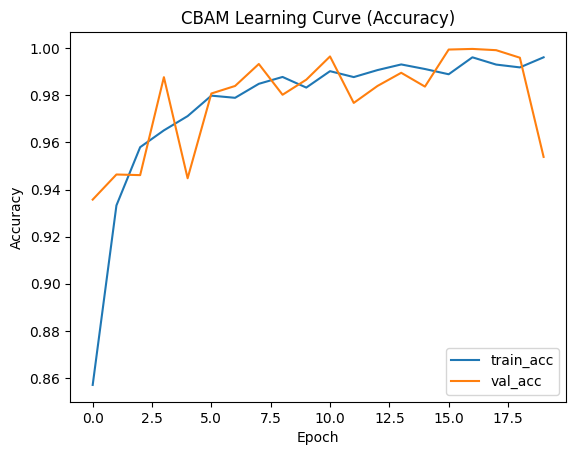

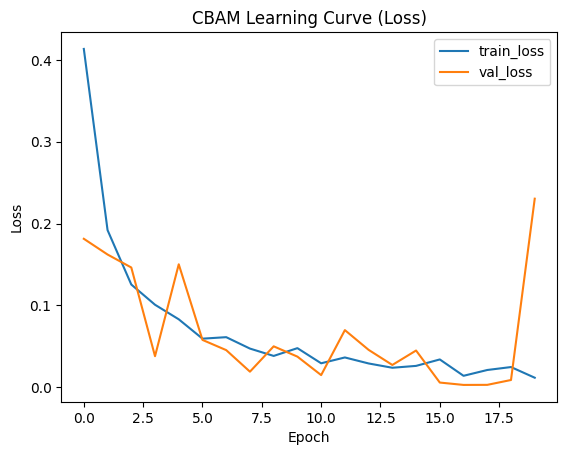


Testing CNN + CBAM...


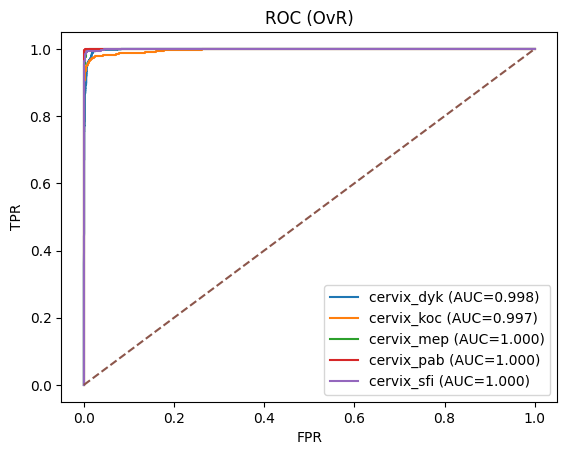

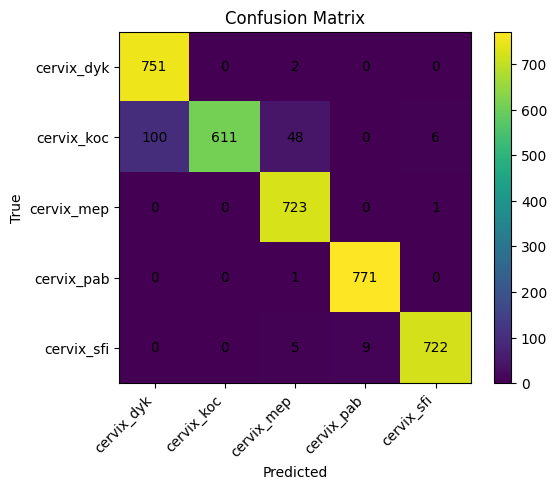

CBAM overall accuracy: 0.9541333333333334


In [7]:
print('Training Baseline CNN...')
base_train_sec, base_valinf_sec, base_hist = fit_with_timing(baseline, train_loader, val_loader, device, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY)
plot_learning_curves(base_hist, title_prefix='Baseline')
print('\nTesting Baseline CNN...')
baseline_metrics = full_test_report(baseline, test_loader, device, class_names)
print('Baseline overall accuracy:', baseline_metrics['overall_accuracy'])

print('\nTraining CNN + CBAM...')
attn_train_sec, attn_valinf_sec, attn_hist = fit_with_timing(attn, train_loader, val_loader, device, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY)
plot_learning_curves(attn_hist, title_prefix='CBAM')
print('\nTesting CNN + CBAM...')
attn_metrics = full_test_report(attn, test_loader, device, class_names)
print('CBAM overall accuracy:', attn_metrics['overall_accuracy'])


In [8]:
import pandas as pd
summary = pd.DataFrame([
    {"Model":"Baseline", "OverallAcc": baseline_metrics["overall_accuracy"], "AUC_macro": baseline_metrics["auc_macro"],
     "TrainSec": base_train_sec, "ValInferSec": base_valinf_sec, "TestSec": baseline_metrics["test_seconds_total"]},
    {"Model":"CBAM", "OverallAcc": attn_metrics["overall_accuracy"], "AUC_macro": attn_metrics["auc_macro"],
     "TrainSec": attn_train_sec, "ValInferSec": attn_valinf_sec, "TestSec": attn_metrics["test_seconds_total"]},
])
summary

,Model,OverallAcc,AUC_macro,TrainSec,ValInferSec,TestSec
0,Baseline,0.994400,0.999922,1970.766332,11.999721,18.158135
1,CBAM,0.954133,0.998796,2710.340334,13.861637,14.751141


In [9]:
@torch.no_grad()
def extract_features(model: nn.Module, loader, device) -> Tuple[np.ndarray, np.ndarray]:
    model.eval(); X_list=[]; y_list=[]
    for x,y in loader:
        x = x.to(device); f = model.forward_features(x)
        X_list.append(f.cpu().numpy()); y_list.append(y.numpy())
    return np.concatenate(X_list,0), np.concatenate(y_list,0)

X_tr, y_tr = extract_features(attn, train_loader, device)
X_te, y_te = extract_features(attn, test_loader, device)

def run_classical_ml(X_train, y_train, X_test, y_test, class_names: List[str]):
    results = {}
    lr = LogisticRegression(max_iter=2000); lr.fit(X_train, y_train); lr_pred = lr.predict(X_test)
    results['logreg'] = {
        'report': classification_report(y_test, lr_pred, target_names=class_names, digits=4),
        'cm': confusion_matrix(y_test, lr_pred).tolist(),
    }
    svm = SVC(kernel='linear'); svm.fit(X_train, y_train); svm_pred = svm.predict(X_test)
    results['svm_linear'] = {
        'report': classification_report(y_test, svm_pred, target_names=class_names, digits=4),
        'cm': confusion_matrix(y_test, svm_pred).tolist(),
    }
    rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train); rf_pred = rf.predict(X_test)
    results['random_forest'] = {
        'report': classification_report(y_test, rf_pred, target_names=class_names, digits=4),
        'cm': confusion_matrix(y_test, rf_pred).tolist(),
    }
    return results

ml_results = run_classical_ml(X_tr, y_tr, X_te, y_te, class_names)
for name, res in ml_results.items():
    print(f"\n== {name} ==\n{res['report']}")


== logreg ==
              precision    recall  f1-score   support

  cervix_dyk     0.9960    0.9987    0.9973       753
  cervix_koc     0.9961    0.9922    0.9941       765
  cervix_mep     0.9972    0.9972    0.9972       724
  cervix_pab     0.9987    0.9987    0.9987       772
  cervix_sfi     0.9973    0.9986    0.9980       736

    accuracy                         0.9971      3750
   macro avg     0.9971    0.9971    0.9971      3750
weighted avg     0.9971    0.9971    0.9971      3750


== svm_linear ==
              precision    recall  f1-score   support

  cervix_dyk     0.9987    1.0000    0.9993       753
  cervix_koc     0.9961    0.9987    0.9974       765
  cervix_mep     1.0000    0.9972    0.9986       724
  cervix_pab     1.0000    0.9987    0.9994       772
  cervix_sfi     1.0000    1.0000    1.0000       736

    accuracy                         0.9989      3750
   macro avg     0.9990    0.9989    0.9989      3750
weighted avg     0.9989    0.9989    0.9989  

In [10]:
os.makedirs('/kaggle/working/outputs', exist_ok=True)
torch.save(baseline.state_dict(), '/kaggle/working/outputs/baseline_state_dict.pth')
torch.save(attn.state_dict(), '/kaggle/working/outputs/attn_cbam_state_dict.pth')
with open('/kaggle/working/outputs/baseline_metrics.json','w') as f: json.dump(baseline_metrics, f, indent=2)
with open('/kaggle/working/outputs/attn_metrics.json','w') as f: json.dump(attn_metrics, f, indent=2)
print('Saved:', os.listdir('/kaggle/working/outputs'))

Saved: ['baseline_metrics.json', 'attn_metrics.json', 'baseline_state_dict.pth', 'attn_cbam_state_dict.pth']
